# **Use ML techniques for SERDES CTLE modeling for IBIS-AMI simulation**  
## Table of contents:  
### 1.**[Motivation](#Motivation)**  <a href='#Motivation'>...</a>
### 2.**[Problem Statements](#Problem Statements)**  <a href='#Problem_Statements'>...</a>
### 3.**[Generate Data](#Generate Data)**  <a href='#Generate_Data'>...</a>
### 4.**[Prepare Data](#Prepare Data)**  <a href='#Prepare_Data'>...</a>
### 5.**[Choose a Model](#Choose a Model)**  <a href='#Choose_a_Model'>...</a>
### 6.**[Training](#Training)**  <a href='#Training'>...</a>
### 7.**[Prediction](#Prediction)**  <a href='#Prediction'>...</a>
### 8.**[Reverse Direction](#Reverse Direction)**  <a href='#Reverse_Direction'>...</a>
### 9.**[Deployment](#Deployment)**  <a href='#Deployment'>...</a>
### 10.**[Conclusion](#Conclusion)**  <a href='#Conclusion'>...</a>

## **Motivation:**<a id = 'Motivation'></a>

One of SPISim's main service is IBIS-AMI modeling and consulting. In most cases, this happens when IC companies is ready to release simulation model for their customers to do system design. We will then require data either from circuit simulation, lab measurements or data sheet spec. in order to create associated IBIS-AMI model.
Occasionally, we also receive request to provide AMI model for architecture planning purpose. In this situation, there is no data or spec. In stead, the client asks to input performance parameters dynamically (not as preset) so that they can evaluate performance at the architecture level before committing to a certain spec. and design accordingly. In such case, we may need to generate data dynamically based on user's input before it will be fed into existing IBIS-AMI models of same kind.
Continues linear equalizer, CTLE, is often used in modern SERDES or even DDR5 design. It is basically a filter in the frequency domain (FD) with various peaking and gain properties. As IBIS-AMI is simulated in the time domain (TD), the core implementations in the model is iFFT to convert into impulse response in TD.
![CtleFDTD](./assets/images/CTLEFDTD.png)

In order to create such CTLE AMI model from user provided spec. on the fly, we would like to avoid time-consuming parameter sweep (in order to match the performance) during runtime of initial set-up call. Thus machine learning techniques may be applied to help use build a prediction model to map input attributes to associated CTLE design parameters so that its FD and TD response can be generated directly. After that, we can feed the data into existing CTLE C/C++ code blocks for channel simulation.

## **Problem Statement:**<a id = 'Problem_Statements'></a>

We would like to build a prediction model such that when user provide a desired CTLE performance parameters, such as DC Gain, peaking frequency and peaking value, this model will map to corresponding CTLE design parameters such as pole and zero locations. Once this is mapped, CTLE frequency response will be generated followed by time-domain impulse response. The resulting IBIS-AMI CTLE model can be used for channel simulation for evaluating such CTLE block's impact in a system... before actual silicon design has been done.

## **Generate Data:**<a id = 'Generate_Data'></a>

### **Overview**   
The model to be build is for nominal (i.e. numerical) prediction for about three to six attributes, depending on the CTLE structure, from four input parameters, namely dc gain, peak frequency, peak value and bandwidth. We will sample the input space randomly (as full combinatorial is impractical) then perform measurement programmingly in order generate enough dataset for modeling purpose.

### **Defing CTLE equations**

We will target the following two most common CTLE structures:   
#### IEEE 802.3bs 200/400Gbe Chip-to-module (C2M) CTLE:
![C2M_CTLE](./assets/images/C2M_CTLE.png)

#### IEEE 802.3bj Channel Operating Margin (COM) CTLE:
![COM_CTLE](./assets/images/COM_CTLE.png)

### **Define sampling points and attributes**

All these pole and zeros values are continuous (numerical), so a sub-sampling from full solution space will be performed. Once frequency response corresponding to each set of configuration is generated, we will measure is dc gain, peak frequency and value, bandwidth (3dB loss from the peak), and frequencies when 10% and 50% gain between dc and peak values happened. The last two attributes will help us increasing the attributes available when creating the prediction model.   
#### Attributes to be extracted:
![CTLEAttr](./assets/images/CTLEAttr.png)

### **Synthesize and measure data**

A python script (in order to be used with subsequent Q-learning w/ OpenAI later) has been written to synthesize these frequency response and perform measurement at the same time. 

#### Quantize and Sampling:
![Sampling](./assets/images/CTLESamp.png)

#### Synthesize:
![Synthesize](./assets/images/CTLEGen.png)

#### Measurement:
![Measurement](./assets/images/CTLEMeas.png)   

The end results after this data generation phase is a 100,000 points dataset for each of the two CTLE structures. We can now proceed for the prediction modeling.

## **Prepare Data:**<a id = 'Prepare_Data'></a>

In [42]:
## Using COM CTLE as an example below:

# Environment Setup:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

prjHome = 'C:/Temp/WinProj/CTLEMdl'
workDir = prjHome + '/wsp/'
srcFile = prjHome + '/dat/COM_CTLEData.csv'

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(workDir, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [43]:
# Read Data
srcData = pd.read_csv(srcFile)
srcData.head()

# Info about the data
srcData.head()
srcData.info()
srcData.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
ID         100000 non-null int64
Gdc        100000 non-null float64
P1         100000 non-null float64
P2         100000 non-null float64
Z1         100000 non-null float64
Gain       100000 non-null float64
PeakF      100000 non-null float64
PeakVal    100000 non-null float64
BandW      100000 non-null float64
Freq10     100000 non-null float64
Freq50     100000 non-null float64
dtypes: float64(10), int64(1)
memory usage: 8.4 MB


,ID,Gdc,P1,P2,Z1,Gain,PeakF,PeakVal,BandW,Freq10,Freq50
count,100000.000000,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000,1.000000e+05,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05
mean,49999.500000,0.574911,1.724742e+10,5.235940e+09,5.241625e+09,0.574911,3.428616e+09,2.374620,1.496343e+10,4.145855e+08,1.136585e+09
std,28867.657797,0.230302,4.323718e+09,2.593138e+09,2.589769e+09,0.230302,4.468393e+09,3.346094,1.048535e+10,5.330043e+08,1.446972e+09
min,0.000000,0.200000,1.000000e+10,1.000000e+09,1.000000e+09,0.200000,0.000000e+00,0.200000,9.965473e+08,0.000000e+00,-1.000000e+00
25%,24999.750000,0.350000,1.350000e+10,3.000000e+09,3.000000e+09,0.350000,0.000000e+00,0.500000,4.770445e+09,0.000000e+00,-1.000000e+00
50%,49999.500000,0.600000,1.700000e+10,5.000000e+09,5.000000e+09,0.600000,0.000000e+00,0.800000,1.410597e+10,0.000000e+00,-1.000000e+00
75%,74999.250000,0.750000,2.100000e+10,7.500000e+09,7.500000e+09,0.750000,7.557558e+09,2.710536,2.386211e+10,8.974728e+08,2.510339e+09
max,99999.000000,0.950000,2.450000e+10,9.500000e+09,9.500000e+09,0.950000,1.516517e+10,16.731528,3.965752e+10,1.768803e+09,4.678211e+09


Seems full justified! Let's plot some distribution...

Saving figure attribute_histogram_plots


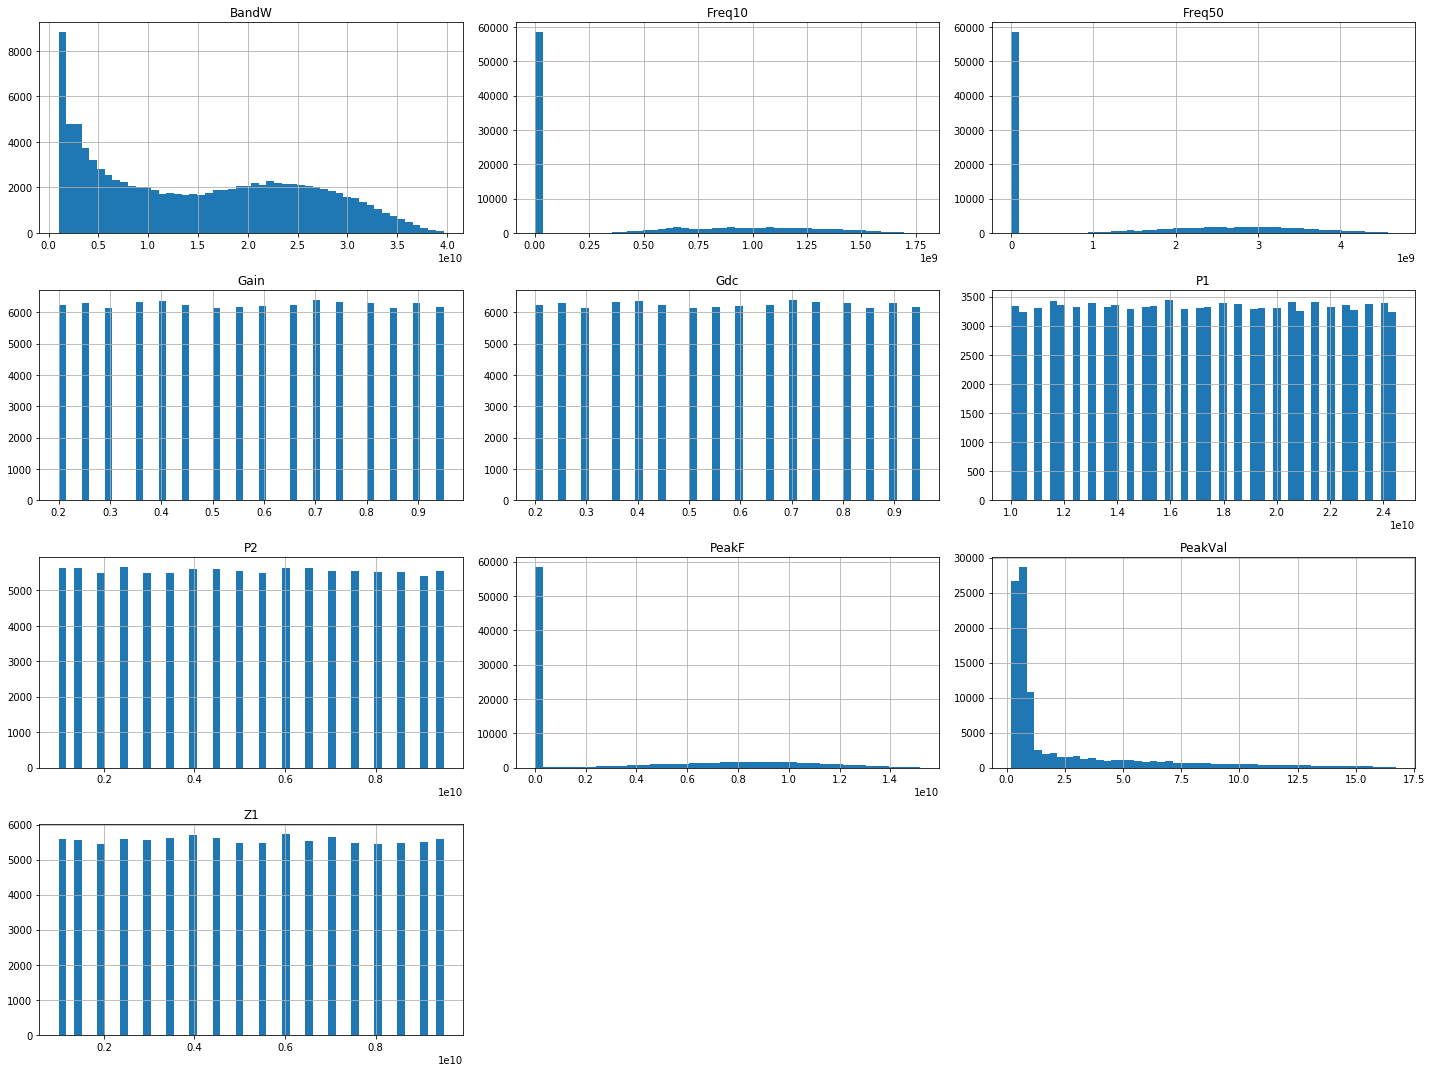

In [44]:
# Drop the ID column
mdlData = srcData.drop(columns=['ID'])

# plot distribution
mdlData.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

There are abnomal high peaks for Freq10, Freq50 and PeakF.
We need to plot the FD data to see what's going on...

#### Error checking:
![NoPeaking](./assets/images/CTLENoPeak.png)

Apparently, this is caused by CTLE without peaking. We can safely remove these data points as they will not be used in actual design.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41588 entries, 1 to 99997
Data columns (total 10 columns):
Gdc        41588 non-null float64
P1         41588 non-null float64
P2         41588 non-null float64
Z1         41588 non-null float64
Gain       41588 non-null float64
PeakF      41588 non-null float64
PeakVal    41588 non-null float64
BandW      41588 non-null float64
Freq10     41588 non-null float64
Freq50     41588 non-null float64
dtypes: float64(10)
memory usage: 3.5 MB
Saving figure attribute_histogram_plots2


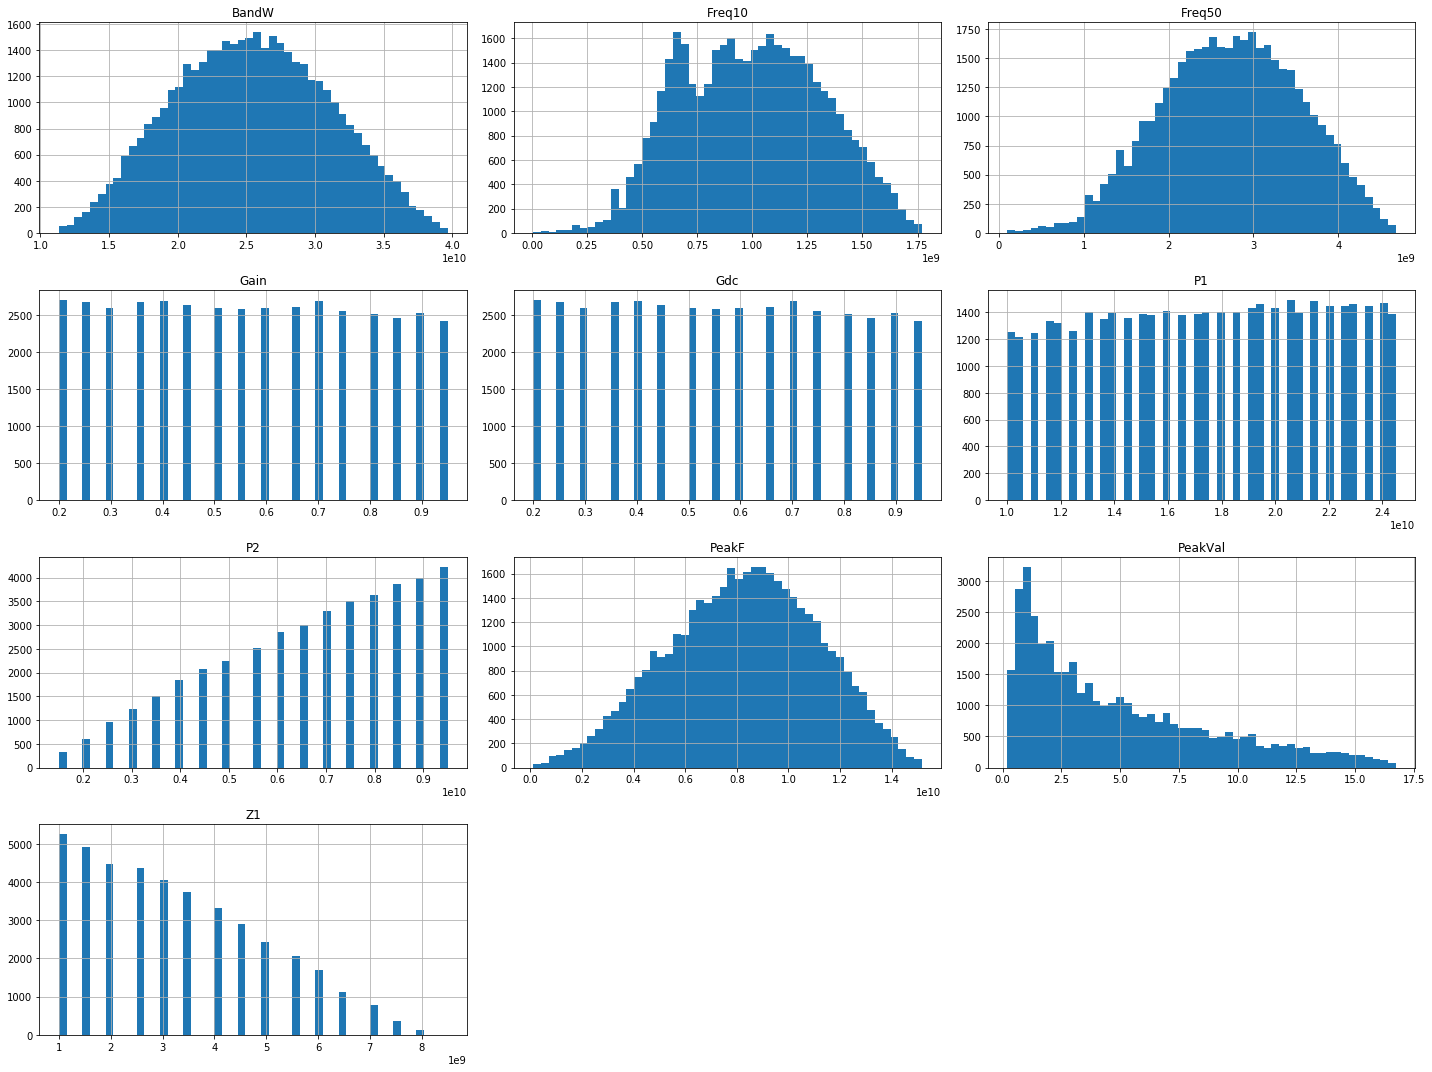

In [45]:
# Drop those freq peak at the beginning (i.e. no peak)
mdlTemp = mdlData[(mdlData['PeakF'] > 100)]
mdlTemp.info()


# plot distribution again
mdlTemp.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots2")
plt.show()

Now the distribution seems good. We can proceed to separate variables (i.e. attributes) and targets

In [46]:
# take this as modeling data from this point
mdlData = mdlTemp

varList = ['Gdc', 'P1', 'P2', 'Z1']
tarList = ['Gain', 'PeakF', 'PeakVal']

varData = mdlData[varList]
tarData = mdlData[tarList]

## **Choose a Model:**<a id = 'Choose_a_Model'></a>

We will use Keras for the modeling framework. While it will call Tensorflow on our machine in this case, the GPU is only used for training purpose. We will use (shallow) neural network for modeling as we want to implement the resulting models in our IBIS-AMI model's C++ codes.

In [47]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

numVars = len(varList)  # independent variables
numTars = len(tarList)  # output targets
nnetMdl = Sequential()
# input layer
nnetMdl.add(Dense(units=64, activation='relu', input_dim=numVars))

# hidden layers
nnetMdl.add(Dropout(0.3, noise_shape=None, seed=None))
nnetMdl.add(Dense(64, activation = "relu"))
nnetMdl.add(Dropout(0.2, noise_shape=None, seed=None))
          
# output layer
nnetMdl.add(Dense(units=numTars, activation='sigmoid'))
nnetMdl.compile(loss='mean_squared_error', optimizer='adam')

# Provide some info
#from keras.utils import plot_model
#plot_model(nnetMdl, to_file= workDir + 'model.png')
nnetMdl.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                320       
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 195       
Total params: 4,675
Trainable params: 4,675
Non-trainable params: 0
_________________________________________________________________


## **Training:**<a id = 'Training'></a>

We will do the 20% training/testing split for the modeling.
Note that we need to scale the input attributes to be between 0~1 so that neuron's activation function can be used to differentiate and calculate weights. These scaler will be applied "inversely" when we predict the actual performance later on.

In [48]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Prepare Training (tran) and Validation (test) dataset
varTran, varTest, tarTran, tarTest = train_test_split(varData, tarData, test_size=0.2)

# scale the data
from sklearn import preprocessing
varScal = preprocessing.MinMaxScaler()
varTran = varScal.fit_transform(varTran)
varTest = varScal.transform(varTest)

tarScal = preprocessing.MinMaxScaler()
tarTran = tarScal.fit_transform(tarTran)

Now we can do the model fit:

In [49]:
# model fit
hist = nnetMdl.fit(varTran, tarTran, epochs=100, batch_size=1000, validation_split=0.1)
tarTemp = nnetMdl.predict(varTest, batch_size=1000)
#predict = tarScal.inverse_transform(tarTemp)
#resRMSE = np.sqrt(mean_squared_error(tarTest, predict))
resRMSE = np.sqrt(mean_squared_error(tarScal.transform(tarTest), tarTemp))
resRMSE

Train on 29943 samples, validate on 3327 samples
Epoch 1/100
29943/29943 [==============================] - 0s 12us/step - loss: 0.0632 - val_loss: 0.0462
Epoch 2/100
29943/29943 [==============================] - 0s 4us/step - loss: 0.0394 - val_loss: 0.0218
Epoch 3/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0218 - val_loss: 0.0090
Epoch 4/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0134 - val_loss: 0.0046
Epoch 5/100
29943/29943 [==============================] - 0s 4us/step - loss: 0.0102 - val_loss: 0.0039
Epoch 6/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0090 - val_loss: 0.0036
Epoch 7/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0082 - val_loss: 0.0032
Epoch 8/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0075 - val_loss: 0.0030
Epoch 9/100
29943/29943 [==============================] - 0s 4us/step - loss: 0.0071 - val_loss: 0.0027
Epoch

Epoch 76/100
29943/29943 [==============================] - 0s 4us/step - loss: 0.0022 - val_loss: 3.5197e-04
Epoch 77/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0022 - val_loss: 3.4445e-04
Epoch 78/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0022 - val_loss: 3.3888e-04
Epoch 79/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0022 - val_loss: 3.3597e-04
Epoch 80/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0022 - val_loss: 3.2317e-04
Epoch 81/100
29943/29943 [==============================] - 0s 4us/step - loss: 0.0021 - val_loss: 3.2205e-04
Epoch 82/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0021 - val_loss: 3.4191e-04
Epoch 83/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0021 - val_loss: 3.2288e-04
Epoch 84/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0021 - val_loss: 3.1419e-04
Epoch 85/1

0.01786895428237113

Let's see how this neural network learns over different Epoch

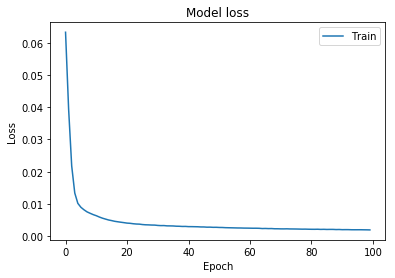

In [50]:
# plot history
plt.plot(hist.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

Looks quite reasonable. We can save the Keras model now together with scaler for later evaluation.

In [51]:
# save model and architecture to single file
nnetMdl.save(workDir + "COM_nnetMdl.h5")

# also save scaler
from sklearn.externals import joblib
joblib.dump(varScal, workDir + 'VarScaler.save') 
joblib.dump(tarScal, workDir + 'TarScaler.save') 
print("Saved model to disk")

Saved model to disk


## **Prediction:**<a id = 'Prediction'></a>

Now let's use this model to make some prediction

In [52]:
# generate prediction
predict = tarScal.inverse_transform(tarTemp)
allData = np.concatenate([varTest, tarTest, predict], axis = 1)
allData.shape
headLst = [varList, tarList, tarList]
headStr = ''.join(str(e) + ',' for e in headLst)
np.savetxt(workDir + 'COMCtleIOP.csv', allData, delimiter=',', header=headStr)

Let's take some 50 points and see how the prediction work

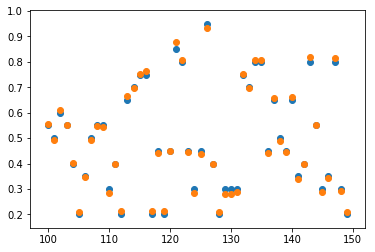

In [53]:
# plot some data
begIndx = 100
endIndx = 150
indxAry = np.arange(0, len(varTest), 1)

plt.scatter(indxAry[begIndx:endIndx], tarTest.iloc[:,0][begIndx:endIndx])
plt.scatter(indxAry[begIndx:endIndx], predict[:,0][begIndx:endIndx])

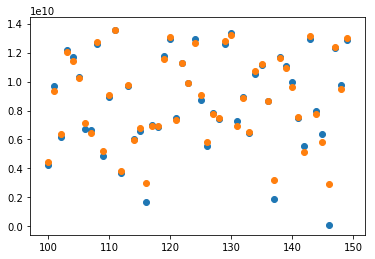

In [54]:
# Plot Peak Freq.
plt.scatter(indxAry[begIndx:endIndx], tarTest.iloc[:,1][begIndx:endIndx])
plt.scatter(indxAry[begIndx:endIndx], predict[:,1][begIndx:endIndx])

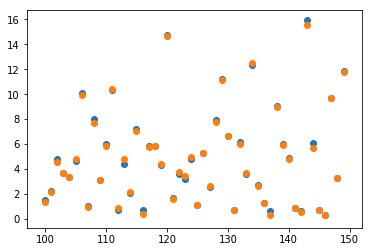

In [55]:
# Plot Peak Value
plt.scatter(indxAry[begIndx:endIndx], tarTest.iloc[:,2][begIndx:endIndx])
plt.scatter(indxAry[begIndx:endIndx], predict[:,2][begIndx:endIndx])

## **Reverse Direction:**<a id = 'Reverse_Direction'></a>

The goal of this modeling is to map performance to CTLE poles and zeros locations. What we just did is the other way around (to make sure such neural network's structure meets our need). Now we needs to reverse the direction for actual modeling. To provide more attributes for better predictions, we will also use  frequencies where 10% and 50% gain happened as part of the input attributes.

In [56]:
tarList = ['Gdc', 'P1', 'P2', 'Z1']
varList = ['Gain', 'PeakF', 'PeakVal', 'Freq10', 'Freq50']

varData = mdlData[varList]
tarData = mdlData[tarList]

In [57]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

numVars = len(varList)  # independent variables
numTars = len(tarList)  # output targets
nnetMdl = Sequential()
# input layer
nnetMdl.add(Dense(units=64, activation='relu', input_dim=numVars))

# hidden layers
nnetMdl.add(Dropout(0.3, noise_shape=None, seed=None))
nnetMdl.add(Dense(64, activation = "relu"))
nnetMdl.add(Dropout(0.2, noise_shape=None, seed=None))
          
# output layer
nnetMdl.add(Dense(units=numTars, activation='sigmoid'))
nnetMdl.compile(loss='mean_squared_error', optimizer='adam')

# Provide some info
#from keras.utils import plot_model
#plot_model(nnetMdl, to_file= workDir + 'model.png')
nnetMdl.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 64)                384       
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 260       
Total params: 4,804
Trainable params: 4,804
Non-trainable params: 0
_________________________________________________________________


In [58]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Prepare Training (tran) and Validation (test) dataset
varTran, varTest, tarTran, tarTest = train_test_split(varData, tarData, test_size=0.2)

# scale the data
from sklearn import preprocessing
varScal = preprocessing.MinMaxScaler()
varTran = varScal.fit_transform(varTran)
varTest = varScal.transform(varTest)

tarScal = preprocessing.MinMaxScaler()
tarTran = tarScal.fit_transform(tarTran)

In [59]:
# model fit
hist = nnetMdl.fit(varTran, tarTran, epochs=100, batch_size=1000, validation_split=0.1)
tarTemp = nnetMdl.predict(varTest, batch_size=1000)
#predict = tarScal.inverse_transform(tarTemp)
#resRMSE = np.sqrt(mean_squared_error(tarTest, predict))
resRMSE = np.sqrt(mean_squared_error(tarScal.transform(tarTest), tarTemp))
resRMSE

Train on 29943 samples, validate on 3327 samples
Epoch 1/100
29943/29943 [==============================] - 0s 15us/step - loss: 0.0800 - val_loss: 0.0638
Epoch 2/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0578 - val_loss: 0.0457
Epoch 3/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0458 - val_loss: 0.0380
Epoch 4/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0408 - val_loss: 0.0344
Epoch 5/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0378 - val_loss: 0.0317
Epoch 6/100
29943/29943 [==============================] - 0s 4us/step - loss: 0.0354 - val_loss: 0.0299
Epoch 7/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0340 - val_loss: 0.0287
Epoch 8/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0327 - val_loss: 0.0276
Epoch 9/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0315 - val_loss: 0.0265
Epoch

Epoch 78/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0094 - val_loss: 0.0040
Epoch 79/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0093 - val_loss: 0.0040
Epoch 80/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0092 - val_loss: 0.0039
Epoch 81/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0091 - val_loss: 0.0039
Epoch 82/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0091 - val_loss: 0.0039
Epoch 83/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0091 - val_loss: 0.0039
Epoch 84/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0091 - val_loss: 0.0038
Epoch 85/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0090 - val_loss: 0.0039
Epoch 86/100
29943/29943 [==============================] - 0s 3us/step - loss: 0.0089 - val_loss: 0.0038
Epoch 87/100
29943/29943 [====================

0.0589564154176633

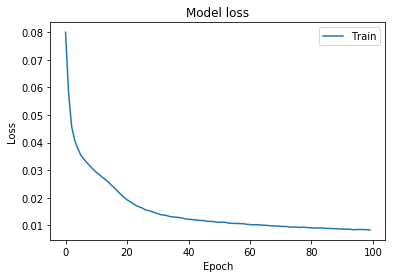

In [60]:
# plot history
plt.plot(hist.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [61]:
# Separated Keras' architecture and synopse weight for later Cpp conversion
from keras.models import model_from_json
# serialize model to JSON
nnetMdl_json = nnetMdl.to_json()
with open("COM_nnetMdl_Rev.json", "w") as json_file:
    json_file.write(nnetMdl_json)
# serialize weights to HDF5
nnetMdl.save_weights("COM_nnetMdl_W_Rev.h5")

# save model and architecture to single file
nnetMdl.save(workDir + "COM_nnetMdl_Rev.h5")
print("Saved model to disk")

# also save scaler
from sklearn.externals import joblib
joblib.dump(varScal, workDir + 'Rev_VarScaler.save') 
joblib.dump(tarScal, workDir + 'Rev_TarScaler.save') 

Saved model to disk


['C:/Temp/WinProj/CTLEMdl/wsp/Rev_TarScaler.save']

In [62]:
# generate prediction
predict = tarScal.inverse_transform(tarTemp)
allData = np.concatenate([varTest, tarTest, predict], axis = 1)
allData.shape
headLst = [varList, tarList, tarList]
headStr = ''.join(str(e) + ',' for e in headLst)
np.savetxt(workDir + 'COMCtleIOP_Rev.csv', allData, delimiter=',', header=headStr)

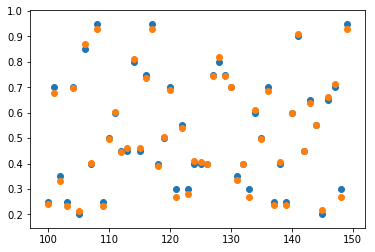

In [63]:
# plot Gdc
begIndx = 100
endIndx = 150
indxAry = np.arange(0, len(varTest), 1)
plt.scatter(indxAry[begIndx:endIndx], tarTest.iloc[:,0][begIndx:endIndx])
plt.scatter(indxAry[begIndx:endIndx], predict[:,0][begIndx:endIndx])

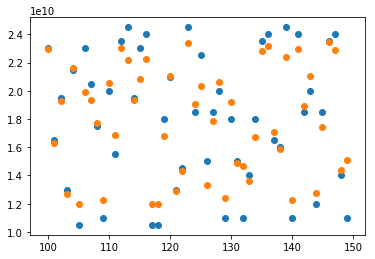

In [64]:
# Plot P1
plt.scatter(indxAry[begIndx:endIndx], tarTest.iloc[:,1][begIndx:endIndx])
plt.scatter(indxAry[begIndx:endIndx], predict[:,1][begIndx:endIndx])

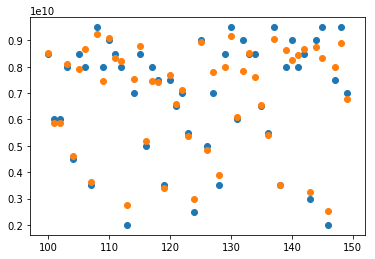

In [65]:
# Plot P2
plt.scatter(indxAry[begIndx:endIndx], tarTest.iloc[:,2][begIndx:endIndx])
plt.scatter(indxAry[begIndx:endIndx], predict[:,2][begIndx:endIndx])

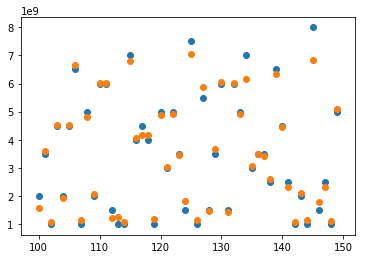

In [66]:
# Plot Z1
plt.scatter(indxAry[begIndx:endIndx], tarTest.iloc[:,3][begIndx:endIndx])
plt.scatter(indxAry[begIndx:endIndx], predict[:,3][begIndx:endIndx])

It seems this "reversed" neural network also work reasonably well. We will further fine-tune later on.

## **Deployment:**<a id = 'Deployment'></a>

Now that we have trained model in Keras' .h5 format, we can translate this model into corresponding cpp codes using Keras2Cpp:

![Keras2Cpp](./assets/images/Keras2Cpp.png)   

Its github repository is here:
[Keras2Cpp](https://github.com/pplonski/keras2cpp)

Resulting file can be compiled together with keras_model.cc, keras_model.h in our AMI library.

## **Conclusion:**<a id = 'Conclusion'></a>

In this post/notebook, we explore the flow to create a neural network based model for CTLE's parameter prediction. Data science techniques have been used. The resulting Keras' model is then converted into C++ code for implementation in our IBIS-AMI library. With this performance based CTLE model, our user can run channel simulation before committing actual silicon design.